In [2]:
import cv2
from cv2 import ximgproc
from matplotlib import pyplot as plt
import math
import numpy as np
from skimage import io
import imageio

img_path='example.jpg'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
print('%d x %d' % (img.shape[0], img.shape[1]))
region_size = 60    # Default 10
ruler = 50          # Enforcement of smoothness, default 10
line_color = (255, 255, 0)
dot_color = (255, 0, 0)
seg_color =  (255, 255, 0)

def get_result(slic):
    mask = slic.getLabelContourMask()
    result = img_rgb.copy()
    result[mask == 255] = seg_color
    return result

799 x 705


In [3]:
gradx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
grady = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
gradmag = cv2.magnitude(gradx, grady)
plt.imshow(gradmag, 'gray', interpolation='none')
cv2.imwrite('gradmag.png', gradmag)

True

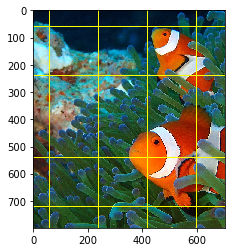

In [4]:
grid = img_rgb.copy()
rows = math.ceil(img.shape[0] / region_size)
cols = math.ceil(img.shape[1] / region_size)
for i in range(1, rows):
    y = region_size * i
    cv2.line(grid, (0, y), (img.shape[1], y), line_color, 1)
for i in range(1, cols):
    x = region_size * i
    cv2.line(grid, (x, 0), (x, img.shape[0]), line_color, 1)
plt.imshow(grid, interpolation='none')

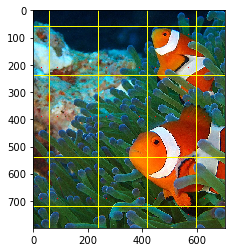

In [5]:
img_init = grid.copy()
for i in range(0, cols):
    for j in range(0, rows):
        x = int(region_size * (i + 0.5))
        y = int(region_size * (j + 0.5))
        cv2.circle(img_init, (x, y), 1, dot_color, -1)
plt.imshow(img_init, interpolation='none')
io.imsave('init.png', img_init)

In [6]:
img_move = grid.copy()
n_moves = 0
for i in range(0, rows):
    for j in range(0, cols):
        x = int(region_size * (j + 0.5))
        y = int(region_size * (i + 0.5))
        area = gradmag[y-1:y+2, x-1:x+2]
        # On image edge
        #area = gradmag[max(0,x-1):min(img.shape[0],x+2), max(0,y-1):min(img.shape[1],y+2)]
        # Outside of image
        if area.size == 0:
            continue
        (xs, ys) = np.where(area == area.min())
        offset_x = xs[0] - 1
        offset_y = ys[0] - 1
        if offset_x != 0 or offset_y != 0:
            #print('(%d, %d)->(%d, %d)' % (x, y, x + offset_x, y + offset_y))
            n_moves += 1
        cv2.circle(img_move, (x + offset_x, y + offset_y), 1, dot_color, -1)
print(n_moves)
plt.imshow(img_move, interpolation='none')
io.imsave('move.png', img_move)

143


156


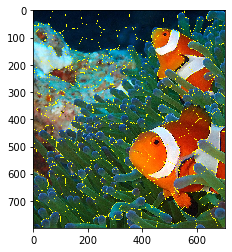

In [7]:
slic = ximgproc.createSuperpixelSLIC(img_lab, ximgproc.SLIC, region_size, ruler)
slic.iterate()
print(slic.getNumberOfSuperpixels())

result = get_result(slic)
io.imsave('slic.png', result)

slic.enforceLabelConnectivity()
result = get_result(slic)
plt.imshow(result, interpolation='none')
io.imsave('slic_post.png', result)

In [8]:
slic = ximgproc.createSuperpixelSLIC(img_lab, ximgproc.SLIC, region_size, ruler)
imgs = [grid]
for i in range(1, 10):
    slic.iterate(1)
    result = get_result(slic)
    io.imsave('slic_iter%d.png' % i, result)
    imgs.append(result)
imageio.mimwrite('slic_iter.gif', imgs, fps=2)

In [9]:
rulers = [10, 20, 30, 40, 50]
for ruler in rulers:
    slic = ximgproc.createSuperpixelSLIC(img_lab, ximgproc.SLIC, region_size, ruler)
    slic.iterate()
    slic.enforceLabelConnectivity()
    result = get_result(slic)
    io.imsave('slic_ruler%d.png' % ruler, result)